In [1]:
import sys
sys.path.append('/global/homes/p/portmanm/timedomain/gwtarget/')

from astropy.io import fits
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord, match_coordinates_sky, Angle
from astropy.time import Time

from gw_skymap import plot_mollmap, plot_cartmap, compute_quantiles

import matplotlib.pyplot as plt
import healpy as hp
import numpy as np
import pandas as pd
import glob
import sys

import sqlite3
import os

# From https://github.com/desihub/timedomain/blob/master/gwtarget/gw_skymap.py
# Because I was having trouble importing again

def compute_quantiles(proportions, samples):
    """Get quantiles of HEALPix probability map.

    Parameters:
    -----------
    proportions: list
        list of containment level to make contours for.
        E.g [0.68,0.9]
    samples: array
        array of values read in from healpix map
        E.g samples = hp.read_map(file)

    Returns:
    --------
    levels: list
        List of map values corresponding to a given containment level.
    """
    levels = []
    sorted_samples = list(reversed(list(sorted(samples))))
    nside = hp.pixelfunc.get_nside(samples)
    sample_points = np.array(hp.pix2ang(nside,np.arange(len(samples)))).T
    for proportion in proportions:
        level_index = (np.cumsum(sorted_samples) > proportion).tolist().index(True)
        level = (sorted_samples[level_index] + (sorted_samples[level_index+1] if level_index+1 < len(samples) else 0)) / 2.0
        levels.append(level)
    return levels

In [2]:
# From ALeRCE_ledgermaker https://github.com/alercebroker/alerce_client
# I have had trouble importing this before so here it goes
import requests
#import matplotlib as mpl
#import matplotlib.pyplot as plt
#import pandas as pd
from alerce.core import Alerce
from alerce.exceptions import APIError

alerce_client = Alerce()

def access_alerts(lastmjd=None, classifier='stamp_classifier', class_names=['SN', 'AGN']):
    if type(class_names) is not list:
        raise TypeError('Argument `class_names` must be a list.')
        
    dataframes = []
    for class_name in class_names:
        data = alerce_client.query_objects(classifier=classifier,
                                           class_name=class_name, 
                                           order_by='oid',
                                           order_mode='ASC',
                                           page_size=1000,
                                           format='pandas')
        
        if lastmjd is not None:
            select = data['lastmjd'] >= lastmjd
            data = data[select]
            
        dataframes.append(data)
    
    return pd.concat(dataframes).sort_values(by='lastmjd')

In [3]:
def read_gwfile(filepath: str, hdu_num = 1):
    
    properties = {}
    
    try:
        with fits.open(filepath) as hdu1:
    
            hdr = hdu1[hdu_num].header
        
            properties["mjd"] = hdr["MJD-OBS"]
            properties["nside"] = hdr["NSIDE"]
            properties["nest"] = True if hdr["ORDERING"] == "NESTED" else False #save myself some time here
            
            #data_table = Table(hdu1[hdu_num].data) #columns
            #properties["prob"] = data_table["PROB"].data
        
            #targ_id = data_table['TARGETID']
            #targ_ra = data_table['TARGET_RA'].data # Now it's a numpy array
            #targ_dec = data_table['TARGET_DEC'].data
            #targ_mjd = data_table['MJD'][0] some have different versions of this so this is a *bad* idea... at least now I know the try except works!
            
    except:
        filename = filepath.split("/")[-1]
        print("Could not open or use:", filename)
        print("In path:", filepath)
        print("Trying the next file if it exists...")
        return properties #np.array([]), np.array([]), np.array([])
    
    #if transient_candidate:
    #    targ_mjd = filepath.split("/")[-1].split("_")[-2] #to grab the date
    #    targ_mjd = targ_mjd[:4]+"-"+targ_mjd[4:6]+"-"+targ_mjd[6:] # Adding dashes for Time
    #    targ_mjd = Time(targ_mjd).mjd
    
    return properties #targ_ra, targ_dec, targ_mjd

In [5]:
with fits.open(gwfile) as hdu1:
    hdr = hdu1[1].header
    print(hdr["MJD-OBS"])

58585.22967804404


In [4]:
# For each fits file, look at one month before
#today = Time.now().mjd

In [4]:
gwfile = 'GW190412_combined_skymap.fits.gz'

In [5]:
gw_properties = read_gwfile(gwfile)
alerts = access_alerts(lastmjd = gw_properties["mjd"] - 30)
alerts_ra = alerts['meanra'].to_numpy()
alerts_dec = alerts['meandec'].to_numpy()
#print(alerts)

In [6]:
gw_map = hp.read_map(gwfile)#, nest = gw_properties["nest"])

/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 1024
  warnings.warn("NSIDE = {0:d}".format(nside))
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = NESTED in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  

/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:486: UserWarning: Ordering converted to RING
  warnings.warn("Ordering converted to RING")
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/projaxes.py:541: UserWarning: 0.0 180.0 -180.0 180.0
  warnings.warn(
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/projaxes.py:656: UserWarning: The interval between parallels is 30 deg -0.00'.
  warnings.warn(
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/projaxes.py:664: UserWarning: The interval between meridians is 45 deg 0.00'.
  warnings.warn(


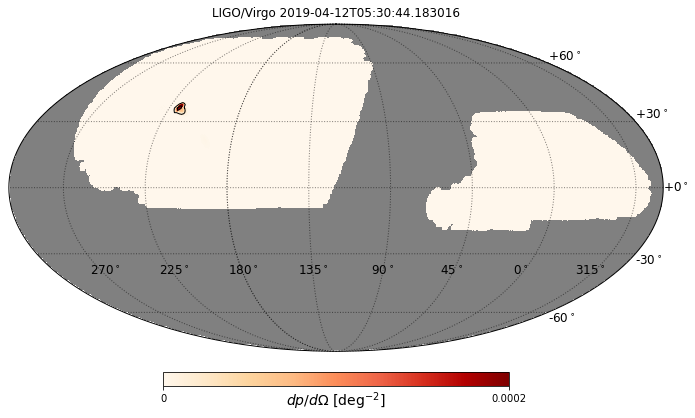

In [7]:
fig = plot_mollmap(gwfile, rot = 120, path_to_mask = '/global/u2/p/portmanm/timedomain/gwtarget/')
#projplot(alerts_ra, alerts_dec, lonlat = True, rot = 120)

/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 1024
  warnings.warn("NSIDE = {0:d}".format(nside))
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = NESTED in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  

[(33.0, 39.0), (221.0, 214.0)]

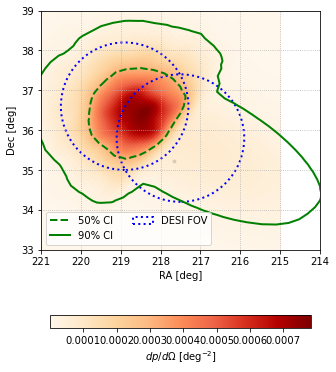

In [28]:
fig = plot_cartmap(gwfile, tile_ra = [218.9,217.5], tile_dec = [36.6,35.8], targ_ra = alerts_ra, targ_dec = alerts_dec, angsize = 3)
#fig = plt.figure()
ax = fig.gca()
ax.set(xlim=(221, 214), ylim=(33,39))

In [7]:
# Load sample of resolved DR9 target catalog using HEALPixels above threshold in the GW map.
# Get list of pixels above threshold defined by level.
#gwmap = hp.read_map(gwfile)
#npix = len(gwmap)
#nside = hp.npix2nside(npix)

#tree_name = "kdtree_" + str(today - 30)

#theta_array = np.pi/180*(90 - alerts_dec)
#phi_array = np.pi/180*alerts_ra

transient_pix_locs = hp.ang2pix(gw_properties["nside"], alerts_ra, alerts_dec, lonlat = True, nest = gw_properties["nest"])
#print(transient_pix_locs.shape)

In [8]:
# Following the conventions here - https://github.com/desihub/timedomain/blob/master/gwtarget/gw_dr9.ipynb
npix = len(gw_map)
lev90 = compute_quantiles([0.9], gw_map)[0]
#print(lev90)
pixels = hp.ring2nest(gw_properties["nside"], np.arange(npix)) #np.arange(npix) 
pix90 = pixels[gw_map > lev90]

#print(sum(gw_properties["prob"])) #[np.where(gw_properties["prob"] > 0.0001)]
#print(transient_pix_locs)

In [9]:
# Area of 90% C.I.
# Still something wonky here... not matching Segev's values but I'll take it for now seeing as how it's not super important
area = 4*np.pi*len(pix90)/npix * (180/np.pi)**2
print('A = {:.1f} deg^2'.format(area))

A = 19.0 deg^2


In [12]:
#vec90 = hp.pix2vec(gw_properties["nside"], pix90, nest = gw_properties["ordering"])
#poly_pix = hp.query_polygon(gw_properties["nside"], vec90, inclusive = True, nest = gw_properties["ordering"])
#print(sorted(poly_pix))
#print(sorted(transient_pix_locs))
#print(sorted(poly_pix))

# Per https://github.com/desihub/timedomain/blob/master/gwtarget/gw_dr8.ipynb
#hp.ring2nest(gw_properties["nside"],
trans_in_prob_region = np.isin(transient_pix_locs, pix90) #np.intersect1d(transient_pix_locs, poly_pix)
print("Any matches?", np.any(trans_in_prob_region))
#print(trans_in_prob_region.shape)
ra, dec = hp.pix2ang(gw_properties["nside"], transient_pix_locs[trans_in_prob_region], nest = gw_properties["nest"], lonlat = True)

Any matches? True


[(33.0, 39.0), (222.0, 213.0)]

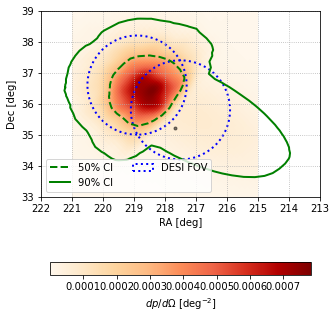

In [11]:
fig = plot_cartmap(gwfile, tile_ra = [218.9,217.5], tile_dec = [36.6,35.8], targ_ra = ra, targ_dec = dec, angsize = 3)
#fig = plt.figure()
ax = fig.gca()
ax.set(xlim=(222, 213), ylim=(33,39))

320000
0.01985566088038582
0.00010610101209106227
0.00018069649153531453
0.00014267496003998574
0.00010948773791936704
0.00021071565608006028
0.00035652916496628907
0.0003405198907171201
0.00018144140785625418
0.0004037647936896567
0.0005524446518397982
0.000622261040505661
0.00035530953605283813
0.00010408920277416902
0.00027241109574390203
0.0005138143220871259
0.0006926481391597984
0.0007454678853643867
0.00048442615980026816
0.00012425832724618488
0.00030278615966369154
0.0005702176184379163
0.0007274855990947756
0.0007051156070303687
0.0005066225895741809
0.00016900928567034688
0.00012152078449800344
0.0002828975013766941
0.00044620684658451895
0.0005875805851630236
0.00047101702372480446
0.00035209754159544547
0.00014938701625982474
0.0001780135195785057
0.0003198054807784759
0.00034559951689682925
0.0003389885492167399
0.00023550298720506862
0.00010569696104423422
0.0001301511807270044
0.0001801650259590579
0.0002081428791600646
0.00015856560661103725
0.00011966992233052171


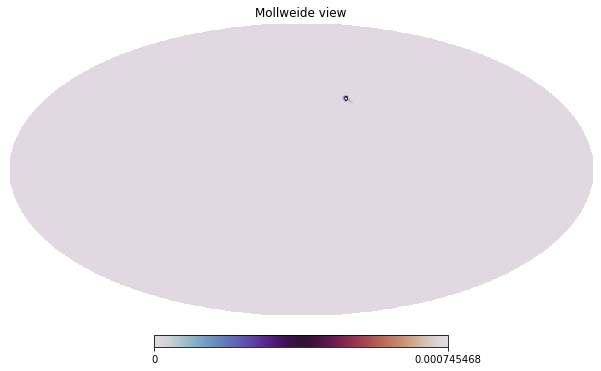

In [89]:
#hp.mollview(transient_pix_locs)
#twod_map = hp.mollview(gw_map, nest = True, rot = -110, cmap = "twilight", return_projected_map = True)
#print(twod_map.size)
#condition = np.isfinite(twod_map) #np.where(twod_map > 0.00000001) and np.isfinite(twod_map) #np.where(twod_map < 1000) # and twod_map < 10000)
#valid = np.extract(condition, twod_map)
#print(sum(twod_map[condition]))
#for i in twod_map[condition]:
#    if i > 0.0001:
#        print(i)